# Predição de links por métodos clássicos
Neste notebook exploramos a predição de links na base de dados de disciplinas dos alunos por meio de métodos clássicos.

In [1]:
from data_processing import load_student_data, get_optativas
dados = load_student_data()

dados['todos']

,ID_ANONIMO,CR,PERIODO,INGRESSO,CODIGO,ANO,PERIODO.1,NOTA,CH,SITUACAOALUNO
0,7034.0,0,1,19/08/15,ES70R,2015.0,2.0,0,30.0,Desistente
1,7034.0,0,1,19/08/15,FI71M,2015.0,2.0,0,60.0,Desistente
2,7034.0,0,1,19/08/15,IF61C,2015.0,2.0,0,90.0,Desistente
3,7034.0,0,1,19/08/15,MA71B,2015.0,2.0,0,90.0,Desistente
4,7034.0,0,1,19/08/15,IF61B,2015.0,2.0,0,60.0,Desistente
...,...,...,...,...,...,...,...,...,...,...
2804,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2805,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2806,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2807,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
import networkx as nx
import matplotlib.pyplot as plt
import sklearn.model_selection as skl

def get_subset_all():
    return dados['todos']

def get_subset_split_bystudent(test_size : float):
    _subset = skl.train_test_split(dados['formados'].ID_ANONIMO, test_size = test_size)
    return dados['formados'][dados['formados']["ID_ANONIMO"].isin(_subset)]

def get_subset_split_all(test_size : float):
    return skl.train_test_split(dados['formados'], test_size = test_size)


G = nx.Graph()

subset = get_subset_all()

optativas = get_optativas()

G.add_nodes_from(optativas)
G.add_nodes_from(subset.ID_ANONIMO.unique())

G.add_nodes_from(subset)


for x in subset.values:
    x[7] = float(str(x[7]).replace(',','.'))
    if(x[7] != x[7] or x[7] <= 0):
        x[7] = 0.01

    if(x[4] in optativas):
        G.add_edge(x[0], x[4], weight=1/x[7])

In [31]:
centrality = nx.degree_centrality(G)

centrality = sorted(centrality.items(), key=lambda item: -item[1])

print("Degree centrality: ", centrality)

Degree centrality:  [('ES70N', 0.19242333132892364), ('CSH30', 0.14732411304870716), ('FI70A', 0.11425135297654841), ('FI70D', 0.11244738424533976), ('GE70F', 0.10102224894768491), ('ES70B', 0.08238123872519543), ('CSV30', 0.04990980156343957), ('MA70C', 0.043896572459410706), ('CSH42', 0.04028863499699339), ('CSR41', 0.03788334335538184), ('CSM41', 0.027660853878532773), ('CSR44', 0.026458208057727), ('CSR42', 0.02164762477450391), ('EL6CB', 0.02164762477450391), ('CSM43', 0.021046301864101023), ('CSI53', 0.020444978953698137), ('CSE40', 0.019242333132892364), ('CSV40', 0.017438364401683705), ('EL6BC', 0.017438364401683705), ('CSM40', 0.017438364401683705), ('ED70T', 0.017438364401683705), ('ES70J', 0.01683704149128082), ('CSB41', 0.016235718580877932), ('CSB51', 0.016235718580877932), ('CSI41', 0.016235718580877932), ('CSB53', 0.015634395670475046), ('CSR43', 0.01503307276007216), ('CSA44', 0.014431749849669273), ('EL6CC', 0.014431749849669273), ('EL6EE', 0.014431749849669273), ('EL6

In [38]:
path = nx.shortest_path(G, source=202266, target=160791, weight="weight")
length = nx.shortest_path_length(G, source=202266, target = 160791, weight="weight")

print(f"Shortest path: {path}, Length: {length}")

Shortest path: [202266, 'CSA41', 202701.0, 'MA7AV', 160791], Length: 0.46785714285714286


In [60]:
from networkx.algorithms import community
communities = list(community.louvain_communities(G))
for x in communities:
    disc_list = []
    for y in x:
        if str(y).__contains__('.'):
            disc_list.append(y)
    if(disc_list.__len__() > 1):
        print(disc_list)
    

[101569.0, 143746.0, 80579.0, 179652.0, 94343.0, 156233.0, 119436.0, 160846.0, 213596.0, 161181.0, 136222.0, 104797.0, 65057.0, 93854.0, 190499.0, 107939.0, 186024.0, 96951.0, 186036.0, 90741.0, 96887.0, 119544.0, 109693.0]
[198535.0, 160776.0, 235601.0, 202259.0, 202261.0, 215513.0, 147679.0, 232482.0, 230179.0, 230181.0, 230182.0, 179624.0, 235885.0, 116974.0, 230638.0, 208882.0, 150078.0, 160767.0]
[124800.0, 136002.0, 130371.0, 245261.0, 186224.0, 190684.0, 241309.0, 155679.0]
[155520.0, 157060.0, 155655.0, 109713.0, 160791.0, 136734.0, 136224.0, 90787.0, 229544.0, 194218.0, 186037.0, 165685.0, 145077.0, 94395.0, 118844.0, 94397.0, 198718.0, 212672.0, 128961.0, 212674.0, 213594.0, 150878.0, 193634.0, 198372.0, 179944.0, 161257.0, 180984.0, 126330.0, 115579.0]
[83464.0, 125626.0, 155966.0, 55055.0]
[151556.0, 138245.0, 165893.0, 165892.0, 165894.0, 151558.0, 165895.0, 172041.0, 165898.0, 172044.0, 172046.0, 172047.0, 103432.0, 177170.0, 114709.0, 118807.0, 105495.0, 114713.0, 190493

# Desenho

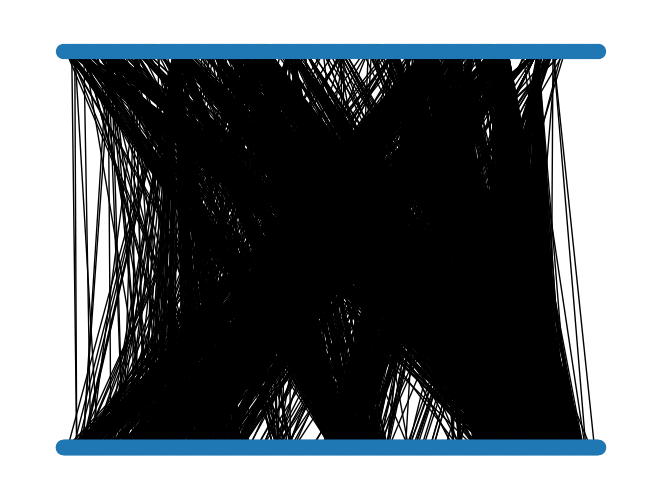

In [36]:
pos = nx.bipartite_layout(G, subset.ID_ANONIMO.unique(), align='horizontal')
nx.draw(G, pos, with_labels=False,  font_size=10, font_weight='bold', node_size=100)
#edge_labels = nx.get_edge_attributes(G, "weight")
#nx.draw_networkx_edge_labels(G, pos, edge_labels)
plt.show()